#####Carichiamo il dataset:

In [ ]:
!wget --user=corso --password=p2021corso http://www.grip.unina.it/download/corso/GANfacesDataset.zip
!unzip -q -n GANfacesDataset.zip

--2021-06-14 07:36:33--  http://www.grip.unina.it/download/corso/GANfacesDataset.zip
Resolving www.grip.unina.it (www.grip.unina.it)... 143.225.28.237
Connecting to www.grip.unina.it (www.grip.unina.it)|143.225.28.237|:80... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="corso"
Reusing existing connection to www.grip.unina.it:80.
HTTP request sent, awaiting response... 200 OK
Length: 9367837920 (8.7G) [application/zip]
Saving to: ‘GANfacesDataset.zip’

GANfacesDataset.zip 100%[===================>]   8.72G  8.96MB/s    in 1h 49m  

2021-06-14 09:25:55 (1.36 MB/s) - ‘GANfacesDataset.zip’ saved [9367837920/9367837920]



#####Escludiamo le immagini ProGAN: 

In [ ]:
import os 
import shutil 

In [ ]:
os.makedirs("ProGAN") 

shutil.move("/content/GANfacesDataset/ProGAN256","ProGAN")

'ProGAN/ProGAN256'

#####Dividiamo il dataset in tre subset, considerando il 70% per il training, il 10% per la validazione e il 20% per il test. Per farlo, sfruttiamo le funzionalità del modulo "splitfolders". 

In [ ]:
!pip install split_folders

import splitfolders

In [ ]:
input_folder = "GANfacesDataset"
output = "GANDataset"
splitfolders.ratio(input_folder, output, ratio=(.7,.1,.2))

Copying files: 12000 files [03:40, 54.31 files/s] 


#####Prepariamo i dati per la classificazione binaria, reale vs sintentico, usando le funzioni Keras ImageDataGenerator, insieme con il metodo flow_from_directory. Questo metodo prevede l'impiego di cartelle per validazione e addestramento. In ciascuna di esse, devono comparire tante sotto-cartelle, con le corrispondenti immagini, quante classi per la classificazione. 


In [ ]:
#TRAINING 

os.chdir("/content/GANDataset/train")
os.makedirs("vere")
os.makedirs("false")

shutil.move("pristine1024","vere")
shutil.move("pristine256","vere")

shutil.move("RelGAN256","false")
shutil.move("StartGAN256","false")
shutil.move("Style2GAN1024","false")
shutil.move("StyleGAN1024","false")

'false/StyleGAN1024'

In [ ]:
#VALIDAZIONE

os.chdir("/content/GANDataset/val")
os.makedirs("vere")
os.makedirs("false")

shutil.move("pristine1024","vere")
shutil.move("pristine256","vere")

shutil.move("RelGAN256","false")
shutil.move("StartGAN256","false")
shutil.move("Style2GAN1024","false")
shutil.move("StyleGAN1024","false")

'false/StyleGAN1024'

In [ ]:
#Importiamo i singoli moduli di interesse

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 
import numpy as np 

In [ ]:
img_height, img_width = (224,224) #dimensioni per le immagini in ingresso
batch_size = 64                   #dimesione del batch

train_data_dir = r"/content/GANDataset/train/" #percorso alla directory di training
valid_data_dir = r"/content/GANDataset/val/"   #percorso alla directory di validation

#####Definiamo la funzione di preprocessamento per le immagini in ingresso alla rete, così realizziamo data-augmentation sui SOLI dati di training nella forma di un blurring gaussiano, rotazioni randomatiche di multipli interni di 90°  e con un ritaglio al centro di 224x224 pixel.

In [ ]:
import cv2          #per farlo impieghiamo le funzionalità offerte dal modulo cv2

def crop_top(img):
  M,N,P = img.shape
  h = int(M/2) 
  k = int(N/2)
  crop_img = img[h-112:h+112, k-112:k+112] 
  return crop_img

def rotate(img):
  rows,cols = img.shape[:2]
  k = np.random.random_integers(low=1, high=4) #vogliamo rotazioni di multipli interi di 90° 
  M = cv2.getRotationMatrix2D((cols/2,rows/2),k*90,1) 
  dst = cv2.warpAffine(img,M,(cols,rows)) 
  return dst

def blur(img):
  img = crop_top(img)
  img = rotate(img)
  
  i=np.random.uniform(0.0,3.0) #sigma varia in un intervallo di reali in maniera randomatica
  k = np.random.randint(low=6*i+1)
  if k%2==1:                                #se k è dispari, ok
    y=cv2.GaussianBlur(img,(k,k),sigmaX=i)
    return y
  else:                                     #k è pari, allora rendo dispari le dimensione della finestra scorrevole. 
    y=cv2.GaussianBlur(img,(k+1,k+1),sigmaX=i)
    return y


In [ ]:
#Creiamo il generatore per il training: 

train_datagen = image.ImageDataGenerator(
    rescale=1/255.0,                        #con questo parametro riportiamo le immagini nel range [0,1] (sono immagini a colori)
    rotation_range=90,
    preprocessing_function=blur)

#train_datagen = image.ImageDataGenerator(
#    rescale=1/255.0,                       
#   rotation_range=90,
#    zca_whitening=False,
#    zca_epsilon=1e-06,
#    shear_range=0.2, 
#    preprocessing_function=blur)          #si è tentati di irrobustire la fase di pre-processamento, distorcendo le immagini e rendendole più luminose, tuttavia non sono stati riscontrati miglioramenti significativi in termini di robustezza
                                          
train_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_height, img_width),
    batch_size=batch_size, 
    class_mode='categorical')                         #ovvero, rappresentazione one-hot: ogni etichetta rappresentata come un vettore di lunghezza pari al numero di classi

Found 8400 images belonging to 2 classes.


In [ ]:
#Creiamo il generatore per la validazione:

valid_datagen = image.ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function=crop_top)

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir, 
    target_size=(img_height, img_width),
    batch_size=batch_size, 
    class_mode='categorical')

Found 1200 images belonging to 2 classes.


In [ ]:
#Definiamo la funzione di scheduling per il learning rate: 

from math import exp

def scheduler(epoch, lr):
  if epoch < 2:             
    return lr
  else:                     # a partire dalla seconda epoca decrementiamo il lr di 1e-0.1
    return lr * exp(-0.1)

#####Adoperiamo ResNet50 come modello base della nostra rete. Preaddestrata su ImageNet, ne escludiamo gli ultimi strati fully-connected (per poi sostituirli con 1-2 strati Dense, con cui particolarizziamo la backbone al nostro caso specifico) e ne "congeliamo" i primi 35. 

In [ ]:
base_model= ResNet50(weights='imagenet', input_shape=(img_height, img_width, 3), include_top=False)

model = Sequential()                      #costruiamo la rete sequenzialmente 
model.add(base_model) 
model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.2))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.2)) #escludo random 5 input ad ogni ciclo di update.
model.add(Dense(2, activation='softmax')) #vogliamo una distribuzione di probabilità =>softmax.

model.summary()

#abbiamo sperimentato inserendo strati di dropout tra i 2 dense e tra lo strato di pooling e il primo dense, non abbiamo, tuttavia, riscontrato cambiamenti 
#in positivo delle prestazioni

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
for layer in base_model.layers[:35]: #rendiamo non addestrabili i primi 35 strati della rete
  layer.trainable = False

#####Usiamo l'ottimizzatore Adam, nella sua variante AMSgrad in fase di compilazione e la categorical cross-entropy per la funzione di loss. 

In [ ]:
opt = Adam(learning_rate=2e-05, amsgrad=True) #provare anche con 3e-05
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy', 'AUC'])
round(model.optimizer.lr.numpy(), 5)

2e-05

In [ ]:
callback = LearningRateScheduler(scheduler, verbose=1)
history = model.fit_generator(train_generator, epochs=12, verbose=1, callbacks=[callback], validation_data=valid_generator) #addestriamo
round(model.optimizer.lr.numpy(), 5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  if sys.path[0] == '':



Epoch 00001: LearningRateScheduler reducing learning rate to 1.9999999494757503e-05.
132/132 [==============================] - 412s 3s/step - loss: 0.6256 - accuracy: 0.6623 - auc: 0.7169 - val_loss: 0.6354 - val_accuracy: 0.6500 - val_auc: 0.6938


2e-05

#####Riportiamo l'andamento delle metriche valutate: 

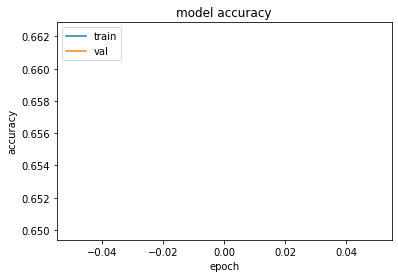

In [ ]:
#ACCURACY: 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

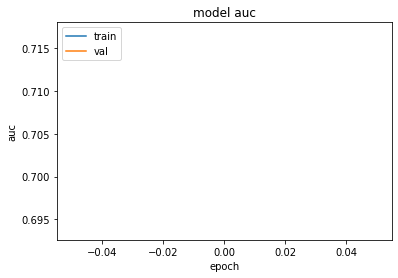

In [ ]:
#AREA UNDER ROC CURVE: 

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

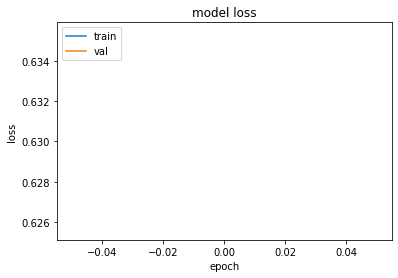

In [ ]:
#LOSS FUNCTION: 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#####FASE DI TEST: 

In [ ]:
os.chdir("/content/GANDataset/test")
os.makedirs("pauso")
os.makedirs("vere")
os.makedirs("false")

In [ ]:
#Per una prima fase di test su RelGAN256:

shutil.move("pristine1024","vere")
shutil.move("pristine256","vere")

shutil.move("StartGAN256","pauso")
shutil.move("Style2GAN1024","pauso")
shutil.move("StyleGAN1024","pauso")

shutil.move("RelGAN256","false")

shutil.move("pauso", "/content")

'/content/pauso'

In [ ]:
test_data_dir = r"/content/GANDataset/test"    #percorso alla directory di test

In [ ]:
#Creiamo il generatore per il test: 

test_datagen = image.ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function=crop_top)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1200 images belonging to 2 classes.


In [ ]:
#Predizione e valutazione delle metriche: 

predictions = model.predict(test_generator,verbose=1)
test_loss, test_acc, test_auc = model.evaluate(test_generator, verbose=1)
print('\nTest accuracy: {}, \nArea under curve: {} '.format(test_acc, test_auc))

19/19 [==============================] - 22s 1s/step - loss: 0.8392 - accuracy: 0.3792 - auc: 0.3632

Test accuracy: 0.3791666626930237, 
Area under curve: 0.363243043422699 


#####Seconda GAN.

In [ ]:
#Fase di test sulle StartGAN256:

os.chdir("/content/pauso")
shutil.move("StartGAN256","/content/GANDataset/test/false")

os.chdir("/content/GANDataset/test/false")
shutil.move("RelGAN256","/content/pauso")

'/content/pauso/RelGAN256'

In [ ]:
test_data_dir = r"/content/GANDataset/test"    #percorso alla directory di test

In [ ]:
#Creiamo il generatore per il test: 

test_datagen = image.ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function=crop_top)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1200 images belonging to 2 classes.


In [ ]:
#Predizione e valutazione delle metriche: 

predictions = model.predict(test_generator,verbose=1)
test_loss, test_acc, test_auc = model.evaluate(test_generator, verbose=1)
print('\nTest accuracy: {}, \nArea under curve: {} '.format(test_acc, test_auc))

19/19 [==============================] - 22s 1s/step - loss: 0.8155 - accuracy: 0.3950 - auc: 0.4289

Test accuracy: 0.39500001072883606, 
Area under curve: 0.42892777919769287 


#####Terza GAN.

In [ ]:
#Fase di test sulle StyleGAN1024:

os.chdir("/content/pauso")
shutil.move("StyleGAN1024","/content/GANDataset/test/false")

os.chdir("/content/GANDataset/test/false")
shutil.move("StartGAN256","/content/pauso")

'/content/pauso/StartGAN256'

In [ ]:
test_data_dir = r"/content/GANDataset/test"    #percorso alla directory di test

In [ ]:
#Creiamo il generatore per il test: 

test_datagen = image.ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function=crop_top)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1200 images belonging to 2 classes.


In [ ]:
#Predizione e valutazione delle metriche: 

predictions = model.predict(test_generator,verbose=1)
test_loss, test_acc, test_auc = model.evaluate(test_generator, verbose=1)
print('\nTest accuracy: {}, \nArea under curve: {} '.format(test_acc, test_auc))

19/19 [==============================] - 40s 2s/step - loss: 0.8596 - accuracy: 0.3417 - auc: 0.3266

Test accuracy: 0.34166666865348816, 
Area under curve: 0.3266322910785675 


#####Quarta GAN: 

In [ ]:
#Fase di test sulle Style2GAN1024:

os.chdir("/content/pauso")
shutil.move("Style2GAN1024","/content/GANDataset/test/false")

os.chdir("/content/GANDataset/test/false")
shutil.move("StyleGAN1024","/content/pauso")

'/content/pauso/StyleGAN1024'

In [ ]:
test_data_dir = r"/content/GANDataset/test" 

In [ ]:
#Creiamo il generatore per il test: 

test_datagen = image.ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function=crop_top)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1200 images belonging to 2 classes.


In [ ]:
#Predizione e valutazione delle metriche: 

predictions = model.predict(test_generator,verbose=1)
test_loss, test_acc, test_auc = model.evaluate(test_generator, verbose=1)
print('\nTest accuracy: {}, \nArea under curve: {} '.format(test_acc, test_auc))

19/19 [==============================] - 40s 2s/step - loss: 0.8257 - accuracy: 0.3892 - auc: 0.3993

Test accuracy: 0.3891666531562805, 
Area under curve: 0.3993357717990875 


#####Analisi di robustezza: 

In [ ]:
#Fase di test sulle ProGAN256:

os.chdir("/content")
shutil.move("ProGAN","/content/GANDataset/test/false")

os.chdir("/content/GANDataset/test/false")
shutil.move("Style2GAN1024","/content/pauso")

'/content/pauso/Style2GAN1024'

In [ ]:
test_data_dir = r"/content/GANDataset/test" 

In [ ]:
#Creiamo il generatore per il test: 

test_datagen = image.ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function=crop_top)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 2800 images belonging to 2 classes.


In [ ]:
#Predizione e valutazione delle metriche: 

predictions = model.predict(test_generator,verbose=1)
test_loss, test_acc, test_auc = model.evaluate(test_generator, verbose=1)
print('\nTest accuracy: {}, \nArea under curve: {} '.format(test_acc, test_auc))

44/44 [==============================] - 28s 640ms/step - loss: 0.6699 - accuracy: 0.6418 - auc: 0.6415

Test accuracy: 0.641785740852356, 
Area under curve: 0.6415109038352966 


#####Codice per la fase di test "in the wild": 

In [ ]:
img = image.load_img('filename.png', target_size = (img_width, img_height)) #in luogo di filename inserire il nome di un'immagine preventivamente caricata in colab
img = image.img_to_array(img) #convertiamo l'immagine in un numpy array 
img = np.expand_dims(img, axis = 0) #si espandono le dimensioni dell'array nella direzione orizzonatale

y_pred = model.predict(img)

plt.figure()
plt.bar(np.arange(2), y_pred[0])
plt.show()